In [130]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [131]:
import numpy as np
import numdifftools as nd
"""
Specify the generator parameters
"""
ratio = 6.9

Tdp = 5.33
Tqp = 1.05
H = 13*ratio
KD = 0*ratio
Xd = 1.942/ratio
Xq = 1.921/ratio
Xdp = 0.374/ratio
Xqp = Xdp
Xl = 0.214/ratio
Rs = 0

KA1 = 900
TA1 = 0.045
KE1 = 1.0
TE1 = 0.78
Aex1 = 0.00325
Bex1 = 0.795
KC1 = 0.156
KD1 = 1.1792
TF1 = 0.69
KF1 = 0.01


KA2 = 54
TA2 = 0.69
KE2 = 0.1
TE2 = 1.0
Aex2 = 0.00325
Bex2 = 0.795
KC2 = 0.156
KD2 = 1.1792
TF2 = 1.19
KF2 = 0.001


def f_Vdq(x):
    Eqp1 = x[0]
    Edp1 = x[1]
    delta1 = x[2]
    w1 = x[3]
    E1 = (Edp1 + 1j * Eqp1) * np.exp(1j * (delta1 - np.pi / 2))
    # print(E1)
    # print(delta1)

    Eqp2 = x[7]
    Edp2 = x[8]
    delta2 = x[9]
    w2 = x[10]
    E2 = (Edp2 + 1j * Eqp2) * np.exp(1j * (delta2 - np.pi / 2))
    # print(E2)
    # print(delta2)

    Vdq = np.zeros((2, 1), dtype=complex)
    Z13 = 3.8E-4 + 1j * 1.216E-2  #
    Z23 = 3.8E-4 + 1j * 1.184E-2  #
    Z34 = 3.57E-3 + 1j * 3.362E-2  #

    #     Z13 = 0.002599+1j*0.083936
    #     Z23 = 0.002589+1j*0.081646
    #     Z34 = 0.024633+1j*0.231978

    # Y-Delta transform
    Z12 = Z13 + Z23 + (Z13 * Z23) / Z34;
    # print(Z12)
    Z24 = Z23 + Z34 + (Z23 * Z34) / Z13;
    # print(Z24)
    Z14 = Z13 + Z34 + (Z13 * Z34) / Z23;
    # print(Z14)

    Y12 = 1 / Z12
    Y24 = 1 / Z24
    Y14 = 1 / Z14

    # Generator Xdp
    Y1 = 1 / (1j * Xdp);
    Y2 = Y1;
    C = np.linalg.solve(np.array([[Y12 + Y14 + Y1, -Y12], [-Y12, Y12 + Y24 + Y2]]),
                        np.array([[Y1, 0, Y14], [0, Y2, Y24]]))
    # print(C)

    D = np.array([[np.exp(1j * (np.pi / 2 - delta1)), 0], [0, np.exp(1j * (np.pi / 2 - delta2))]], dtype=complex)
    # print(D)
    # print(np.matmul(D,C))
    y = np.array([[E1], [E2], [1]], dtype=complex)
    Vdq = np.matmul(np.matmul(D, C), y)
    return Vdq


def f_Efd(Ve, XadIfd, Kc):
    if Ve <= 0:
        Efd = 0
    else:
        IN = Kc * XadIfd / Ve
        if IN <= 0:
            Efd = Ve
        elif IN <= 0.433:
            Efd = Ve - 0.577 * Kc * XadIfd
        elif IN < 0.75:
            Efd = np.sqrt(0.75 * Ve ** 2 - (Kc * XadIfd) ** 2)
        elif IN <= 1:
            Efd = 1.732 * Ve - 1.732 * Kc * XadIfd
        else:
            Efd = 0
    return Efd


def f_Eqp1(x):
    Eqp1 = x[0]
    Edp1 = x[1]
    Ve1 = x[6]
    # rint("Ve1="+str(Ve1))
    Vf1 = x[4]
    Vd1 = np.real(f_Vdq(x)[0])
    Vq1 = np.imag(f_Vdq(x)[0])
    Id1 = (Rs * (Edp1 - Vd1) + Xqp * (Eqp1 - Vq1)) / (Rs * Rs + Xdp * Xqp)
    XadIfd = Eqp1 + (Xd - Xdp) * Id1
    Vfe = KD1 * XadIfd + KE1 * Ve1 + Aex1 * np.exp(Bex1 * Ve1)
    # rint("Vfe1="+str(Vfe))
    Efd = f_Efd(Ve1, XadIfd, KC1)
    # rint("Efd1="+str(Efd))
    return 1 / Tdp * (-Eqp1 - (Xd - Xdp) * Id1 + Efd)


def f_Eqp2(x):
    Eqp2 = x[7]
    Edp2 = x[8]
    Vf2 = x[11]
    Ve2 = x[13]
    Vd2 = np.real(f_Vdq(x)[1])
    Vq2 = np.imag(f_Vdq(x)[1])
    Id2 = (Rs * (Edp2 - Vd2) + Xqp * (Eqp2 - Vq2)) / (Rs * Rs + Xdp * Xqp)
    XadIfd = Eqp2 + (Xd - Xdp) * Id2
    Vfe = KD2 * XadIfd + KE2 * Ve2 + Aex2 * np.exp(Bex2 * Ve2)
    Efd = f_Efd(Ve2, XadIfd, KC2)
    return 1 / Tdp * (-Eqp2 - (Xd - Xdp) * Id2 + Efd)


# print(f_Eqp1(x))
# print(f_Eqp2(x))

def f_Edp1(x):
    Eqp1 = x[0]
    Edp1 = x[1]
    Vd1 = np.real(f_Vdq(x)[0])
    Vq1 = np.imag(f_Vdq(x)[0])
    Iq1 = (-Xdp * (Edp1 - Vd1) + Rs * (Eqp1 - Vq1)) / (Rs * Rs + Xdp * Xqp)
    # print("Iq1="+str(Iq1))
    # print(-Edp1 + (Xq - Xqp)*Iq1)
    return 1 / Tqp * (-Edp1 + (Xq - Xqp) * Iq1)


def f_Edp2(x):
    Eqp2 = x[7]
    Edp2 = x[8]
    Vd2 = np.real(f_Vdq(x)[1])
    Vq2 = np.imag(f_Vdq(x)[1])
    Iq2 = (-Xdp * (Edp2 - Vd2) + Rs * (Eqp2 - Vq2)) / (Rs * Rs + Xdp * Xqp)
    return 1 / Tqp * (-Edp2 + (Xq - Xqp) * Iq2)


# print(f_Edp1(x))
# print(f_Edp2(x))

def f_delta1(x):
    return x[3] * 120 * np.pi


def f_delta2(x):
    return x[10] * 120 * np.pi


# print(f_delta1(x))
# print(f_delta2(x))

def f_VF1(x):
    Eqp1 = x[0]
    Edp1 = x[1]
    Vf1 = x[4]
    Ve1 = x[6]
    Vd1 = np.real(f_Vdq(x)[0])
    Vq1 = np.imag(f_Vdq(x)[0])
    Id1 = (Rs * (Edp1 - Vd1) + Xqp * (Eqp1 - Vq1)) / (Rs * Rs + Xdp * Xqp)
    XadIfd = Eqp1 + (Xd - Xdp) * Id1
    Vfe = KD1 * XadIfd + KE1 * Ve1 + Aex1 * np.exp(Bex1 * Ve1)
    # print(Vfe)
    # print(Vf1)
    return (Vfe - Vf1) / TF1


def f_VF2(x):
    Eqp2 = x[7]
    Edp2 = x[8]
    Vf2 = x[11]
    Ve2 = x[13]
    Vd2 = np.real(f_Vdq(x)[1])
    Vq2 = np.imag(f_Vdq(x)[1])
    Id2 = (Rs * (Edp2 - Vd2) + Xqp * (Eqp2 - Vq2)) / (Rs * Rs + Xdp * Xqp)
    XadIfd = Eqp2 + (Xd - Xdp) * Id2
    Vfe = KD2 * XadIfd + KE2 * Ve2 + Aex2 * np.exp(Bex2 * Ve2)
    # print(Vfe)
    # print(Vf2)
    return (Vfe - Vf2) / TF2


# print(f_VF1(x))
# print(f_VF2(x))

"""
Va_dot = (Vsum - Vr)/Ta;
"""


def f_VA1(x):
    Vref = 1.0453853623552374
    #     Vref = x[16]
    Eqp1 = x[0]
    Edp1 = x[1]
    Vf1 = x[4]
    Va1 = x[5]
    Ve1 = x[6]
    Vd1 = np.real(f_Vdq(x)[0])
    Vq1 = np.imag(f_Vdq(x)[0])
    Id1 = (Rs * (Edp1 - Vd1) + Xqp * (Eqp1 - Vq1)) / (Rs * Rs + Xdp * Xqp)
    XadIfd = Eqp1 + (Xd - Xdp) * Id1
    Vfe = KD1 * XadIfd + KE1 * Ve1 + Aex1 * np.exp(Bex1 * Ve1)
    yf = KF1 / TF1 * (Vfe - Vf1)
    Vsum = Vref - np.absolute(f_Vdq(x)[0]) - yf
    return (Vsum - Va1) / TA1


def f_VA2(x):
    Vref = 1.0782820895785585
    #     Vref = x[17]
    Eqp2 = x[7]
    Edp2 = x[8]
    Vf2 = x[11]
    Va2 = x[12]
    Ve2 = x[13]
    Vd2 = np.real(f_Vdq(x)[1])
    Vq2 = np.imag(f_Vdq(x)[1])
    Id2 = (Rs * (Edp2 - Vd2) + Xqp * (Eqp2 - Vq2)) / (Rs * Rs + Xdp * Xqp)
    XadIfd = Eqp2 + (Xd - Xdp) * Id2
    Vfe = KD2 * XadIfd + KE2 * Ve2 + Aex2 * np.exp(Bex2 * Ve2)
    yf = KF2 / TF2 * (Vfe - Vf2)
    Vsum = Vref - np.absolute(f_Vdq(x)[1]) - yf
    return (Vsum - Va2) / TA2


# print(f_VA1(x))
# print(f_VA2(x))

"""
Ve_dot = (KA*Va - Vfe) / Te
"""


def f_VE1(x):
    Eqp1 = x[0]
    Edp1 = x[1]
    Vf1 = x[4]
    Va1 = x[5]
    Ve1 = x[6]
    Vd1 = np.real(f_Vdq(x)[0])
    Vq1 = np.imag(f_Vdq(x)[0])
    Id1 = (Rs * (Edp1 - Vd1) + Xqp * (Eqp1 - Vq1)) / (Rs * Rs + Xdp * Xqp)
    XadIfd = Eqp1 + (Xd - Xdp) * Id1
    Vfe = KD1 * XadIfd + KE1 * Ve1 + Aex1 * np.exp(Bex1 * Ve1)
    return (KA1 * Va1 - Vfe) / TE1


def f_VE2(x):
    Eqp2 = x[7]
    Edp2 = x[8]
    Vf2 = x[11]
    Va2 = x[12]
    Ve2 = x[13]
    Vd2 = np.real(f_Vdq(x)[1])
    Vq2 = np.imag(f_Vdq(x)[1])
    Id2 = (Rs * (Edp2 - Vd2) + Xqp * (Eqp2 - Vq2)) / (Rs * Rs + Xdp * Xqp)
    XadIfd = Eqp2 + (Xd - Xdp) * Id2
    Vfe = KD2 * XadIfd + KE2 * Ve2 + Aex2 * np.exp(Bex2 * Ve2)
    return (KA2 * Va2 - Vfe) / TE2


# print(f_VE1(x))
# print(f_VE2(x))

def sys_fun(x):
    fun = [f_Eqp1, f_Edp1, f_delta1, f_w1, f_VF1, f_VA1, f_VE1, f_Eqp2, f_Edp2, f_delta2, f_w2, f_VF2, f_VA2, f_VE2]

    #     J = np.array([nd.Jacobian(f)(x).ravel() for f in fun])
    #     J = J[:,:14]
    #     lam, v = np.linalg.eig(J)
    #     res = np.append(np.array([f(x).ravel() for f in fun]).ravel(), [lam[4].real,lam[5].real,lam[7].real,lam[8].real])
    #     return res

    return np.array([f(x).ravel() for f in fun]).ravel()

# n is the length of column vector u
def T2_mat(n):
    T2 = np.eye(n**2,dtype=int)
    rmidx = np.triu_indices(n,1)[1]*n + np.triu_indices(n,1)[0]
    T2 = np.delete(T2,rmidx,0)
    return T2


def S2_mat(n):
    S2 = np.eye(n**2,dtype=int)
    rmidx = np.triu_indices(n,1)[1]*n + np.triu_indices(n,1)[0]
    addidx = np.triu_indices(n,1)[0]*n + np.triu_indices(n,1)[1]
    S2[rmidx,addidx] = 1
    S2 = np.delete(S2,rmidx,1)
    return S2

def T3_mat(n):
    Bx3 = [(i,j,k) for i in range(n) for j in range(i,n) for k in range(j,n)] # extracted from x \otimes Bx^2
    x_Bx2 = [(i,j,k) for i in range(n) for j in range(n) for k in range(j,n)] #  x \otimes Bx^2
    Bx3_idx = [x_Bx2.index(i) for i in Bx3]
    rmidx = list(set(range(len(x_Bx2)))-set(Bx3_idx))
    rmele = [x_Bx2[i] for i in rmidx]
    rmele = [tuple(sorted(i)) for i in rmele]
    rmidx_inBx3 = [Bx3.index(i) for i in rmele]
    T3 = np.eye(n*n*(n+1)//2,dtype=int)
    T3 = T3[Bx3_idx]
    return T3

def S3_mat(n):
    Bx3 = [(i,j,k) for i in range(n) for j in range(i,n) for k in range(j,n)] # extracted from x \otimes Bx^2
    x_Bx2 = [(i,j,k) for i in range(n) for j in range(n) for k in range(j,n)] #  x \otimes Bx^2
    Bx3_idx = [x_Bx2.index(i) for i in Bx3]
    rmidx = list(set(range(len(x_Bx2)))-set(Bx3_idx))
    rmele = [x_Bx2[i] for i in rmidx]
    rmele = [tuple(sorted(i)) for i in rmele]
    rmidx_inBx3 = [Bx3.index(i) for i in rmele]
    S3 = np.eye(n*n*(n+1)//2,dtype=int)
    S3 = S3[:,Bx3_idx]
    S3[rmidx,rmidx_inBx3] = 1
    return S3

def Trissian(f_test, x0):
    """
    This function calculates the 3rd order derivative of a function f: R^n -> R
    input: 
        f_test is the function
        x0 where the 3rd order want to be calcuated
    return: 3-D matrix
    """
    Trissian = np.zeros((x0.shape[0],x0.shape[0],x0.shape[0]))
    for i in range(x0.shape[0]):
        h = 0.001
        xp1 = np.array(x0, copy=True) 
        xp1[i] += h
        #print(xp1)
        xp2 = np.array(x0, copy=True) 
        xp2[i] += 2*h
        #print(xp2)
        xm1 = np.array(x0, copy=True) 
        xm1[i] -= h
        #print(xm1)
        xm2 = np.array(x0, copy=True) 
        xm2[i] -= 2*h
        #print(xm2)
        Trissian[i] = (-nd.Hessian(f_test)(xp2) + 8*nd.Hessian(f_test)(xp1)- 8*nd.Hessian(f_test)(xm1) + nd.Hessian(f_test)(xm2))/(12*h)
    return Trissian

In [132]:
who

Aex1	 Aex2	 Bex1	 Bex2	 H	 KA1	 KA2	 KC1	 KC2	 
KD	 KD1	 KD2	 KE1	 KE2	 KF1	 KF2	 Rs	 S2_mat	 
S3_mat	 T2_mat	 T3_mat	 TA1	 TA2	 TE1	 TE2	 TF1	 TF2	 
Tdp	 Tqp	 Trissian	 Xd	 Xdp	 Xl	 Xq	 Xqp	 f_Edp1	 
f_Edp2	 f_Efd	 f_Eqp1	 f_Eqp2	 f_VA1	 f_VA2	 f_VE1	 f_VE2	 f_VF1	 
f_VF2	 f_Vdq	 f_delta1	 f_delta2	 nd	 np	 ratio	 sys_fun	 


In [133]:
import numpy as np
import numdifftools as nd
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline 
pd.set_option('display.float_format', lambda x: '%.6f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from scipy import optimize
np.set_printoptions(precision=25)

In [134]:

# Pm1 = 5.7057429331336316
# Pm2 = 5.5655296329353838

def f_w1(x):
    #     Pm = x[14]
    Eqp1 = x[0]
    Edp1 = x[1]
    w = x[3]
    Vd1 = np.real(f_Vdq(x)[0])
    Vq1 = np.imag(f_Vdq(x)[0])
    Id1 = (Rs * (Edp1 - Vd1) + Xqp * (Eqp1 - Vq1)) / (Rs * Rs + Xdp * Xqp)
    Iq1 = (-Xdp * (Edp1 - Vd1) + Rs * (Eqp1 - Vq1)) / (Rs * Rs + Xdp * Xqp)
    Pe = (Eqp1 * Iq1 - Xdp * Id1 * Iq1 + Edp1 * Id1 + Xqp * Id1 * Iq1)
    return 1 / (2 * H) * (5.69 - Pe - KD * w)


def f_w2(x):
    #     Pm = x[15]
    Eqp2 = x[7]
    Edp2 = x[8]
    w = x[10]
    Vd2 = np.real(f_Vdq(x)[1])
    Vq2 = np.imag(f_Vdq(x)[1])
    Iq2 = (-Xdp * (Edp2 - Vd2) + Rs * (Eqp2 - Vq2)) / (Rs * Rs + Xdp * Xqp)
    Id2 = (Rs * (Edp2 - Vd2) + Xqp * (Eqp2 - Vq2)) / (Rs * Rs + Xdp * Xqp)
    Pe = (Eqp2 * Iq2 - Xdp * Id2 * Iq2 + Edp2 * Id2 + Xqp * Id2 * Iq2)
    return 1 / (2 * H) * (5.63 - Pe - KD * w)

In [135]:
x = np.array([9.8702904764637900e-01, 6.0720200986339867e-01,1.2488635337247085e+00,\
              -8.2222133228430873e-31,  4.8356743414294767e+00,5.3729714904771960e-03,\
              2.3129894806063538e+00,  9.0826094936361890e-01,6.4022044420757318e-01,\
              1.3157812680813068e+00,  3.3279066601270862e-29,2.5467521593576761e+00,\
              4.7162077025142149e-02, 2.1398641868961223e+00])

In [136]:
sys_fun(x)

array([-8.3318801097572719e-17, -3.1720657846433040e-16,
       -3.0997013965550357e-28, -8.7753250466166590e-05,
        0.0000000000000000e+00,  2.9683046144492032e-15,
        0.0000000000000000e+00,  0.0000000000000000e+00,
       -4.2294210461910723e-16,  1.2545912538345359e-26,
        3.5936659456309208e-04, -3.7318420995803582e-16,
        6.0338207860062865e-17,  4.4408920985006262e-16])

In [137]:
sol = optimize.root(sys_fun, x, method='hybr')
all_fun = [f_Eqp1,f_Edp1,f_delta1,f_w1,f_VF1,f_VA1,f_VE1,f_Eqp2,f_Edp2,f_delta2,f_w2,f_VF2,f_VA2,f_VE2]
J = np.array([nd.Jacobian(f)(sol.x).ravel() for f in all_fun])
#display(pd.DataFrame(J))
lam, v = np.linalg.eig(J.T) # Here we want to calculate the left eigenvecs, so use J_org.T; because use left eigvec makes it easier to calc transformation matrix
print(lam)

[-1.0092348497916078e+01+15.523275342135262j
 -1.0092348497916078e+01-15.523275342135262j
 -7.1582023827829744e-01 +5.70473048705587j
 -7.1582023827829744e-01 -5.70473048705587j
  1.6961132742069410e-03 +3.840432148923425j
  1.6961132742069410e-03 -3.840432148923425j
 -5.0410273757293949e+00 +0.j
  3.1410803335863158e-03 +1.291006612112211j
  3.1410803335863158e-03 -1.291006612112211j
 -3.2509468951794016e+00 +0.j
 -1.4227824149101678e+00 +0.8061301292743197j
 -1.4227824149101678e+00 -0.8061301292743197j
 -1.9810718106829635e+00 +0.j
 -8.3624930581946766e-01 +0.j                ]


In [138]:
from scipy.integrate import solve_ivp
def func_ty(t, x): 
    return sys_fun(x)

tend = 1000
x0 = x
sol = solve_ivp(func_ty, [0,tend], x0, method='RK45', t_eval=np.arange(0,tend,1/240))

In [139]:
sol.y.shape

(14, 240000)

In [142]:
tend = 500
x0 = sol.y[:,-1]
sol = solve_ivp(func_ty, [0,tend], x0, method='RK45', t_eval=np.arange(0,tend,1/240))

In [143]:
data = pd.DataFrame(sol.y[:,::8].T)

Text(0.5,0,'time(sec)')

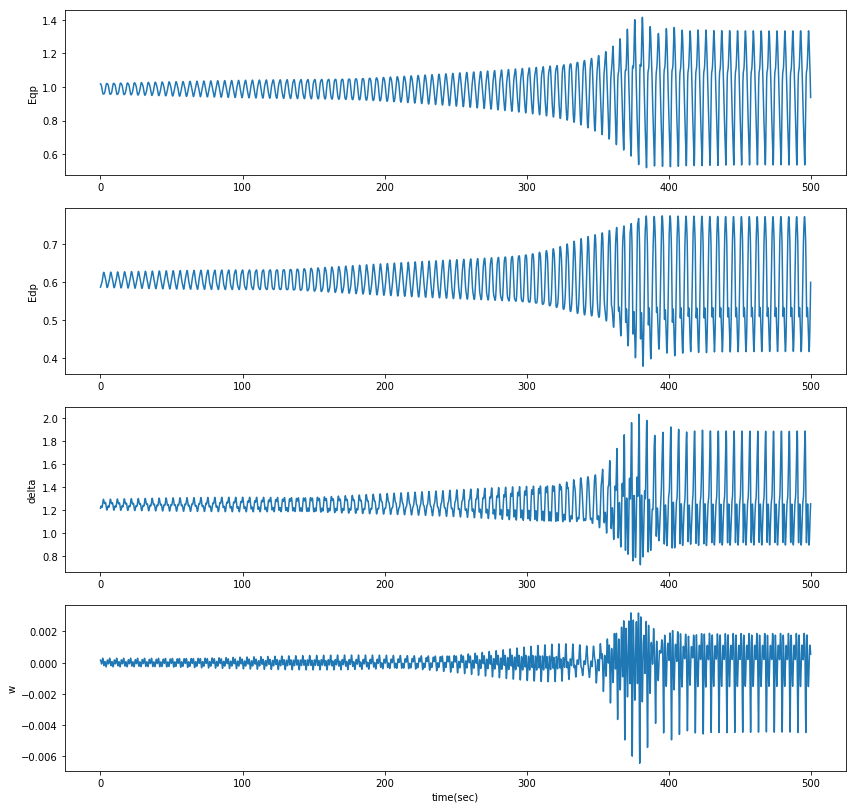

In [144]:
fig, ax = plt.subplots(nrows=4,ncols=1,figsize=(14,14))
ax[0].plot(sol.t[::8], data.iloc[:,0])
ax[1].plot(sol.t[::8], data.iloc[:,1])
ax[2].plot(sol.t[::8], data.iloc[:,2])
ax[3].plot(sol.t[::8], data.iloc[:,3])
ax[0].set_ylabel('Eqp')
ax[1].set_ylabel('Edp')
ax[2].set_ylabel('delta')
ax[3].set_ylabel('w')
ax[3].set_xlabel('time(sec)')

Text(0,0.5,'w2')

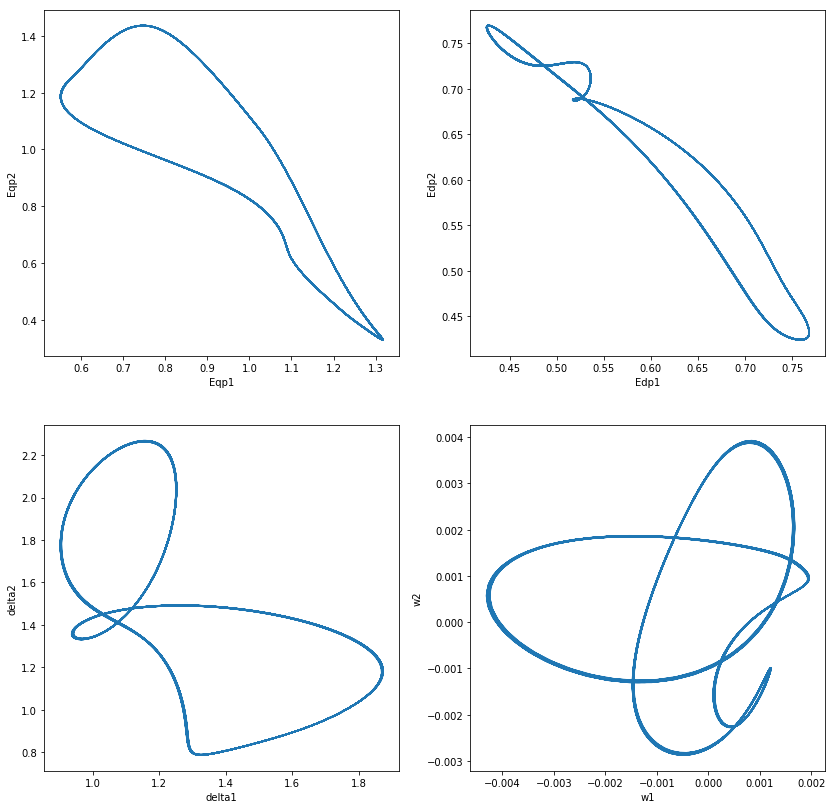

In [247]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(14,14))
start = 2800 * 30
ax[0][0].plot(data.iloc[start:,0],data.iloc[start:,7]);ax[0][0].set_xlabel('Eqp1');ax[0][0].set_ylabel('Eqp2')
ax[0][1].plot(data.iloc[start:,1],data.iloc[start:,8]);ax[0][1].set_xlabel('Edp1');ax[0][1].set_ylabel('Edp2')
ax[1][0].plot(data.iloc[start:,2],data.iloc[start:,9]);ax[1][0].set_xlabel('delta1');ax[1][0].set_ylabel('delta2')
ax[1][1].plot(data.iloc[start:,3],data.iloc[start:,10]);ax[1][1].set_xlabel('w1');ax[1][1].set_ylabel('w2')